In [2]:
%run FeatureEngineering2.ipynb

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## EXPERIMENTS
#### 1. Removing of outliers
results of test: (Train R² / Test R² / MSE / RMSE)

a) no outlier removal: model fits well, but affected by large outliers (0.56, 0.53, 467.04, 21.61)

b) remove x and y outliers: low error, but model trained on less data (0.32, 0.34, 1.72, 1.31) 

c) clip only the target value: balanced — outliers controlled, full dataset used (0.49, 0.48, 3.91, 1.98)
##### Conclusion: We clip only the target value when removing outliers

#### 2. Log transform target value
##### Conclusion: This resulted in very poor results and a negative r^2 value and so we opted to not log tranform the y-values 

#### 3. Apply L2 (Ridge) regularization
LIN REGRESSION:

Cross-Validation R² scores: [0.46127139 0.47412866 0.48215149 0.46826976 0.48893482]

Average R²: 0.4749512242405666

Mean Squared Error: 4.02

RMSE: 2.01

Mean Absolute Error: 1.46

R² Score: 0.46

RIDGE:

Cross-Validation R² scores: [0.46127858 0.47412967 0.48215618 0.46826879 0.48893628]

Average R²: 0.4749538991548706

Mean Squared Error: 4.02

RMSE: 2.01

Mean Absolute Error: 1.46

R² Score: 0.46

##### Conclusion: This resulted in similar results to linear regression and we added a flag to compare results within the same notebook

#### 4. Cross-validation
##### Conclusion: This resulted in similar results through iterations

#### 5. Apply PCA
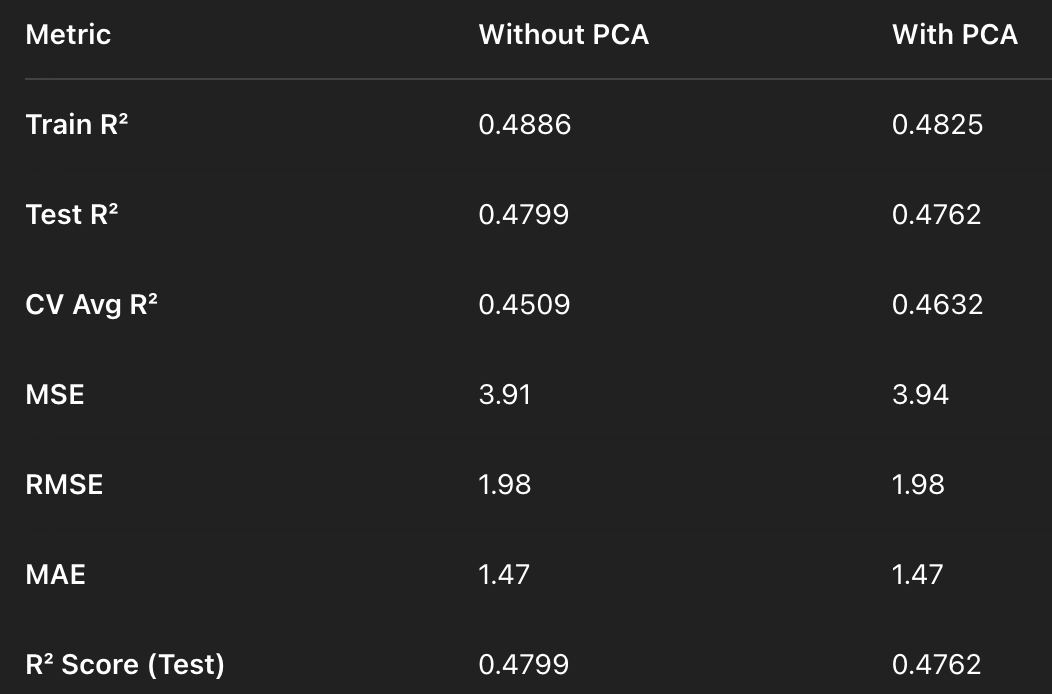
##### Conclusion: Performance was almost the same with and without PCA but we were able to visualize and learn the optimal number of components and keep PCA

In [4]:
# move the target column to the end of the dataframe
target_col = data.pop('Target_Comment_Volume')
data['Target_Comment_Volume'] = target_col

# separate features and target
X = data.iloc[:, :-1]  # features
y = data.iloc[:, -1]  # target

# Experiment 1: we clip only the target value when removing outliers
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
non_outliers = (y >= lower_bound) & (y <= upper_bound)
y = np.clip(y, lower_bound, upper_bound)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # scale before splitting train-test so that all values are in the same range

In [5]:
model_train_flag = "LinReg" # either LinReg or Ridge

In [6]:
# PCA
pca = PCA(n_components=0.95)  # retain 95% variances

if model_train_flag == "LinReg":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', LinearRegression())
    ])
elif model_train_flag == "Ridge":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', Ridge(alpha=10))
    ])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [8]:
# fit pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [9]:
# evaluation
print(f"{model_train_flag} Regression with PCA Results")
print(f"Train R²: {pipeline.score(X_train, y_train):.4f}")
print(f"Test R²: {pipeline.score(X_test, y_test):.4f}")

LinReg Regression with PCA Results
Train R²: 0.4843
Test R²: 0.4835


In [12]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_scaled, y, scoring='r2', cv=cv)
print("Cross-Validation R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

mse = mean_squared_error(y_test, y_pred)  # lec 4, slide 20
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Cross-Validation R² scores: [0.47587037 0.48109966 0.47833582 0.48586821 0.48941297]
Average R²: 0.4821174077195872
Mean Squared Error: 3.85
RMSE: 1.96
Mean Absolute Error: 1.50
R² Score: 0.48


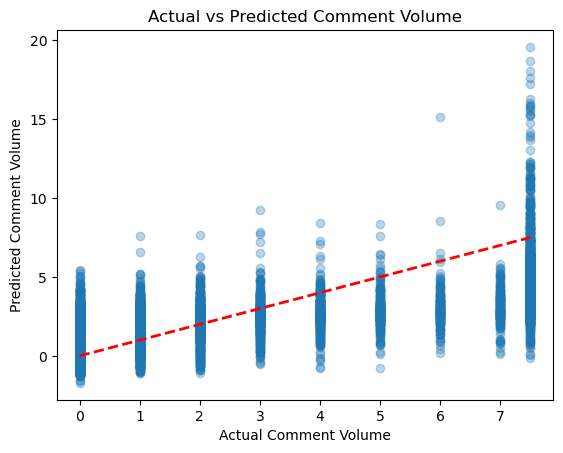

In [13]:
# best = points close to the diagonal
plt.scatter(y_test, y_pred, alpha=0.3)  # alpha=0.3 for semi-transparent dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # red diagonal line
plt.xlabel("Actual Comment Volume")
plt.ylabel("Predicted Comment Volume")
plt.title("Actual vs Predicted Comment Volume")
plt.show()


### Summary
Linear regression proves as a good baseline model and we ran multiple experiments to play around with what would give us the best result.